In [1]:
import warnings

In [2]:
import pandas as pd
import numpy as np

In [3]:
warnings.filterwarnings(action="ignore")

In [4]:
selloutData = pd.read_csv("../dataset/kopo_decision_tree_all_new.csv")
#keyList = ["REGIONID", "PRODUCTGROUP", "PRODUCT", "ITEM"]

selloutData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,A01,PG01,P01,ITEM001,201538,2015,38,1,N,4,N,0.0
1,A01,PG01,P01,ITEM001,201548,2015,48,1,Y,0,N,0.0
2,A01,PG01,P01,ITEM001,201549,2015,49,2,Y,0,N,0.0
3,A01,PG01,P01,ITEM002,201526,2015,26,1,Y,1,N,0.0
4,A01,PG01,P01,ITEM002,201532,2015,32,1,N,4,N,0.0


In [5]:
uniqueSize = len(selloutData.ITEM.unique())
pd.DataFrame(
[[uniqueSize]],columns = ["Data Unique Size"]
)

,Data Unique Size
0,491


# 1.그룹별 데이터의 사이즈 확인

In [6]:
groupKey = ["REGIONID", "PRODUCTGROUP", "PRODUCT", "ITEM"]
groupKey

['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM']

In [7]:
groupData = \
selloutData.groupby(groupKey)["QTY"].agg(["size","mean"]).reset_index()

In [8]:
groupData.rename(columns = {"size":"KNOB"},inplace = True)
groupData.rename(columns = {"mean":"MEAN"},inplace = True)
groupData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,KNOB,MEAN
0,A01,PG01,P01,ITEM001,3,1.333333
1,A01,PG01,P01,ITEM002,2,1.000000
2,A01,PG01,P01,ITEM003,1,2.000000
3,A01,PG01,P01,ITEM004,7,28.857143
4,A01,PG01,P01,ITEM005,8,222.500000


# 2.원본데이터와 그룹핑데이터 머지

In [9]:
mergedData = pd.merge(left=selloutData
        ,right=groupData
        ,on = groupKey
        ,how = "left")

mergedData.head(10)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,KNOB,MEAN
0,A01,PG01,P01,ITEM001,201538,2015,38,1,N,4,N,0.000000,3,1.333333
1,A01,PG01,P01,ITEM001,201548,2015,48,1,Y,0,N,0.000000,3,1.333333
2,A01,PG01,P01,ITEM001,201549,2015,49,2,Y,0,N,0.000000,3,1.333333
3,A01,PG01,P01,ITEM002,201526,2015,26,1,Y,1,N,0.000000,2,1.000000
4,A01,PG01,P01,ITEM002,201532,2015,32,1,N,4,N,0.000000,2,1.000000
5,A01,PG01,P01,ITEM003,201553,2015,53,2,Y,1,N,0.000000,1,2.000000
6,A01,PG01,P01,ITEM004,201501,2015,1,63,Y,1,Y,0.345902,7,28.857143
7,A01,PG01,P01,ITEM004,201502,2015,2,33,N,4,Y,0.345902,7,28.857143
8,A01,PG01,P01,ITEM004,201503,2015,3,7,N,4,N,0.000000,7,28.857143
9,A01,PG01,P01,ITEM004,201504,2015,4,6,Y,2,N,0.000000,7,28.857143


In [10]:
maxKnob = mergedData.KNOB.max()
maxKnob

146

In [11]:
cleansedData = mergedData[mergedData.KNOB >= maxKnob]
cleansedData.reset_index(drop=True, inplace=True)
cleansedData

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,KNOB,MEAN
0,A01,PG02,P03,ITEM043,201501,2015,1,87,Y,1,Y,0.197590,146,497.000000
1,A01,PG02,P03,ITEM043,201502,2015,2,60,N,4,Y,0.197590,146,497.000000
2,A01,PG02,P03,ITEM043,201503,2015,3,51,N,4,N,0.000000,146,497.000000
3,A01,PG02,P03,ITEM043,201504,2015,4,37,Y,2,N,0.000000,146,497.000000
4,A01,PG02,P03,ITEM043,201505,2015,5,136,N,4,Y,0.201205,146,497.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7587,A01,PG05,P15,ITEM376,201737,2017,37,226,N,4,Y,0.271214,146,186.684932
7588,A01,PG05,P15,ITEM376,201738,2017,38,218,N,4,Y,0.271214,146,186.684932
7589,A01,PG05,P15,ITEM376,201739,2017,39,151,N,4,Y,0.245307,146,186.684932
7590,A01,PG05,P15,ITEM376,201740,2017,40,220,N,4,Y,0.245307,146,186.684932


# 3.머지한 데이터에 대해서 KNOB >=146 필터링

In [12]:
def predict_model(onegroup,incorr,defaultVal) :
    from sklearn import tree,ensemble, linear_model
    from sklearn.neighbors import KNeighborsRegressor 

#     predictGroup = cleansedData.groupby(groupKey)
#     len(predictGroup)

#     onegroup= predictGroup.get_group(list(predictGroup.groups)[0])
#     onegroup.shape

    #index를 0번부터 시작하도록 변경

    eachgroup = onegroup.reset_index(drop=True)
    #eachgroup.head()

    # 1. 특성선정 및 데이터 분리

    corrdf = eachgroup.corr(numeric_only=True)
    features = list(corrdf[(abs(corrdf.QTY) > incorr) & (corrdf.QTY < 1)].index)
    #features

    label = ["QTY"]
    
    yearweekStd = 201701

    trainingData_features = eachgroup[eachgroup.YEARWEEK < yearweekStd][features]
    trainingData_label    = eachgroup[eachgroup.YEARWEEK < yearweekStd][label]
    testData_features = eachgroup[eachgroup.YEARWEEK >= yearweekStd][features]
    testData_label    = eachgroup[eachgroup.YEARWEEK >= yearweekStd][label]

    testData_all    = eachgroup[eachgroup.YEARWEEK >= yearweekStd]

    ###과제 
    ###만약 len(features) 없는 경우 predict값은 0 , MAE 산출(모델 3개 이상)
    ###만약 len(features) 존재하면 머신러닝 모델 활용하여 예측(모델 3개 이상)
    ###최적의 모델은 ..... a 모델!
    
    if len(features) <= 0:
        
        if defaultVal == "m" :
            defaultConstant = testData_all.MEAN
        else :
            defaultConstant = 0
            
        testData_all["PREDICT_DT"] = defaultConstant
        testData_all["PREDICT_LR"] = defaultConstant
        testData_all["PREDICT_RF"] = defaultConstant
        testData_all["PREDICT_KNN"] = defaultConstant
        print("features가 0인 케이스")
    else : 

        # 2.모델선언

        model_method = tree.DecisionTreeRegressor(random_state=1)
        model_method_lr = linear_model.LinearRegression()
        model_method_rf = ensemble.RandomForestRegressor(random_state=20)
        model_method_knn = KNeighborsRegressor(11)

        # 3.훈련

        model    = model_method.fit(trainingData_features,trainingData_label)
        model_lr = model_method_lr.fit(trainingData_features, trainingData_label)
        model_rf = model_method_rf.fit(trainingData_features, trainingData_label)
        model_knn = model_method_knn.fit(trainingData_features, trainingData_label)
        # 4. 예측

        predict_dt = model.predict(testData_features)
        predict_lr = model_lr.predict(testData_features)
        predict_rf = model_rf.predict(testData_features)
        predict_knn = model_knn.predict(testData_features)
        testData_all["PREDICT_DT"] = predict_dt
        testData_all["PREDICT_LR"] = predict_lr
        testData_all["PREDICT_RF"] = predict_rf
        testData_all["PREDICT_KNN"] = predict_knn
        #mergedData = pd.concat( [testData_label , predictDf], axis = 1)

    return testData_all

In [13]:
predictPdList = [];
incorrDic = {0.1,0.4,0.45,0.5,0.7}

#LEN 0 일때 DEFAULT 평균으로 설정
defaultval = "m"
for ic in incorrDic :
    pdict = {}
    pdict["incorr"] = ic
    pdict["data"] = cleansedData.groupby(groupKey).apply(predict_model,(ic),(defaultval)).reset_index(drop=True)
    predictPdList.append(pdict)

#LEN 0일때 DEFAULT 0으로 설정
defaultval = "d"
predictPdListdefaultZero = []
for ic in incorrDic :
    pdict = {}
    pdict["incorr"] = ic
    pdict["data"] = cleansedData.groupby(groupKey).apply(predict_model,(ic),(defaultval)).reset_index(drop=True)
    predictPdListdefaultZero.append(pdict)

features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케이스
features가 0인 케

#CASE.1 디폴트=평균값

In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import operator

resultList = []
indexnamelist = []

corPlot = []
dtPlotAvg = []
lrPlotAvg = []
rfPlotAvg = []
knnPlotAvg = []

## 디폴트 평균값으로 설정한 경우
for predictResult in predictPdList :
    treeMAE     = mean_absolute_error(predictResult["data"].QTY,predictResult["data"].PREDICT_DT)
    LinearMAE   = mean_absolute_error(predictResult["data"].QTY,predictResult["data"].PREDICT_LR)
    RandomFoMAE = mean_absolute_error(predictResult["data"].QTY,predictResult["data"].PREDICT_RF)
    KNNMAE      = mean_absolute_error(predictResult["data"].QTY,predictResult["data"].PREDICT_KNN)
    indexnamelist.append("default : 평균,상관계수("+ str(predictResult["incorr"]) + ") MAE")
    
    maeDic = {}
    maeDic["DecisionTreeRegressor"] = treeMAE
    maeDic["LinearRegression"]      = LinearMAE
    maeDic["RandomForestRegressor"] = RandomFoMAE
    maeDic["KNN"] = KNNMAE
    
    corPlot.append(predictResult["incorr"])
    dtPlotAvg.append(treeMAE)
    lrPlotAvg.append(LinearMAE)
    rfPlotAvg.append(RandomFoMAE)
    knnPlotAvg.append(KNNMAE)
    
    #MAE 오름차순 소팅해서 최적 모델명을 확인한다.
    sorted_dic = sorted(maeDic.items(), key=operator.itemgetter(1))
    print(sorted_dic)
    modelName,MAE =  sorted_dic[0]
    maeDic["최적모델판단결과"] = modelName
    resultList.append(maeDic)

defaultAVG = pd.DataFrame(resultList, index = indexnamelist)

[('RandomForestRegressor', 72.15732458293955), ('LinearRegression', 79.81034250460281), ('DecisionTreeRegressor', 82.18180844674748), ('KNN', 117.5305304451646)]
[('RandomForestRegressor', 67.75444445265644), ('DecisionTreeRegressor', 70.26070423001615), ('KNN', 72.00051664840339), ('LinearRegression', 75.61652162786456)]
[('RandomForestRegressor', 67.34845044170888), ('DecisionTreeRegressor', 68.93845563234747), ('KNN', 72.23660306449314), ('LinearRegression', 74.68445992284383)]
[('RandomForestRegressor', 64.99342999835187), ('DecisionTreeRegressor', 66.62833078146697), ('KNN', 67.17268556702234), ('LinearRegression', 74.89838866336206)]
[('RandomForestRegressor', 73.52445141887891), ('DecisionTreeRegressor', 73.54205682446896), ('LinearRegression', 75.0867276642207), ('KNN', 75.2285595293447)]


#CASE.2 디폴트 = 0

In [15]:

resultList = []
indexnamelist = []

corPlot = []
dtPlot = []
lrPlot = []
rfPlot = []
knnPlot = []
## 디폴트 0으로 설정한 경우
for predictResult in predictPdListdefaultZero :
    treeMAE     = mean_absolute_error(predictResult["data"].QTY,predictResult["data"].PREDICT_DT)
    LinearMAE   = mean_absolute_error(predictResult["data"].QTY,predictResult["data"].PREDICT_LR)
    RandomFoMAE = mean_absolute_error(predictResult["data"].QTY,predictResult["data"].PREDICT_RF)
    KNNMAE      = mean_absolute_error(predictResult["data"].QTY,predictResult["data"].PREDICT_KNN)
    indexnamelist.append("default : 0, 상관계수("+ str(predictResult["incorr"]) + ") MAE")
    
    maeDic = {}
    maeDic["DecisionTreeRegressor"] = treeMAE
    maeDic["LinearRegression"]      = LinearMAE
    maeDic["RandomForestRegressor"] = RandomFoMAE
    maeDic["KNN"] = KNNMAE

    corPlot.append(predictResult["incorr"])
    dtPlot.append(treeMAE)
    lrPlot.append(LinearMAE)
    rfPlot.append(RandomFoMAE)
    knnPlot.append(KNNMAE)
    #MAE 오름차순 소팅해서 최적 모델명을 확인한다.
    sorted_dic = sorted(maeDic.items(), key=operator.itemgetter(1))
    print(sorted_dic)
    modelName,MAE =  sorted_dic[0]
    maeDic["최적모델판단결과"] = modelName
    resultList.append(maeDic)
    
defaultZero = pd.DataFrame(resultList, index = indexnamelist)

[('RandomForestRegressor', 72.15732458293955), ('LinearRegression', 79.81034250460281), ('DecisionTreeRegressor', 82.18180844674748), ('KNN', 117.5305304451646)]
[('RandomForestRegressor', 67.82628837051607), ('DecisionTreeRegressor', 70.33254814787576), ('KNN', 72.072360566263), ('LinearRegression', 75.68836554572418)]
[('RandomForestRegressor', 67.52678000556298), ('DecisionTreeRegressor', 69.11678519620162), ('KNN', 72.41493262834726), ('LinearRegression', 74.86278948669796)]
[('RandomForestRegressor', 78.34641388382823), ('DecisionTreeRegressor', 79.98131466694332), ('KNN', 80.52566945249873), ('LinearRegression', 88.2513725488384)]
[('RandomForestRegressor', 139.1315988654851), ('DecisionTreeRegressor', 139.14920427107518), ('LinearRegression', 140.6938751108269), ('KNN', 140.8357069759509)]


In [16]:
finalFrame = pd.concat([defaultAVG,defaultZero], axis=0)
finalFrame.sort_index(inplace=True)
finalFrame

,DecisionTreeRegressor,LinearRegression,RandomForestRegressor,KNN,최적모델판단결과
"default : 0, 상관계수(0.1) MAE",82.181808,79.810343,72.157325,117.530530,RandomForestRegressor
"default : 0, 상관계수(0.4) MAE",70.332548,75.688366,67.826288,72.072361,RandomForestRegressor
"default : 0, 상관계수(0.45) MAE",69.116785,74.862789,67.526780,72.414933,RandomForestRegressor
"default : 0, 상관계수(0.5) MAE",79.981315,88.251373,78.346414,80.525669,RandomForestRegressor
"default : 0, 상관계수(0.7) MAE",139.149204,140.693875,139.131599,140.835707,RandomForestRegressor
"default : 평균,상관계수(0.1) MAE",82.181808,79.810343,72.157325,117.530530,RandomForestRegressor
"default : 평균,상관계수(0.4) MAE",70.260704,75.616522,67.754444,72.000517,RandomForestRegressor
"default : 평균,상관계수(0.45) MAE",68.938456,74.684460,67.348450,72.236603,RandomForestRegressor
"default : 평균,상관계수(0.5) MAE",66.628331,74.898389,64.993430,67.172686,RandomForestRegressor
"default : 평균,상관계수(0.7) MAE",73.542057,75.086728,73.524451,75.228560,RandomForestRegressor


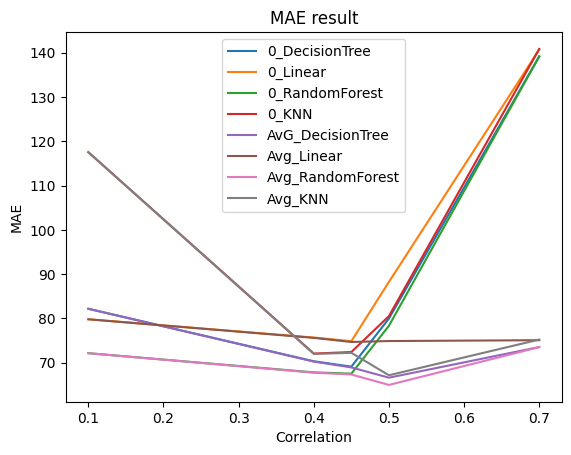

In [17]:
from matplotlib import pyplot as plt
 
plt.plot(corPlot,dtPlot)
plt.plot(corPlot,lrPlot)
plt.plot(corPlot,rfPlot)
plt.plot(corPlot,knnPlot)

plt.plot(corPlot,dtPlotAvg)
plt.plot(corPlot,lrPlotAvg)
plt.plot(corPlot,rfPlotAvg)
plt.plot(corPlot,knnPlotAvg)

plt.xlabel('Correlation')
plt.ylabel('MAE')
plt.title('MAE result')
plt.legend(['0_DecisionTree', '0_Linear', '0_RandomForest','0_KNN',"AvG_DecisionTree","Avg_Linear","Avg_RandomForest","Avg_KNN"])